# Libraries & utilities

In [21]:
from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sns
import time

import pandas as pd
import numpy as np

# To enable HalvingGridSearchCV (Note: method is still experimental)
from sklearn.experimental import enable_halving_search_cv

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, HalvingGridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score

from skopt import BayesSearchCV

# Functions

In [2]:
def formatNewRow(typeOfsearch, nbr_fit, execTime, y_test, y_pred):
    new_row = {
        'typeOfSearch': typeOfsearch,
        "nbrTrains": nbr_fit,
        "executionTime": execTime,
        "accuracy": accuracy_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, zero_division=0.0),
        "F1 score": f1_score(y_test, y_pred)
    }
    return new_row

# Loading the dataset

In [3]:
## READING AND CLEANING DATA
data, target = load_breast_cancer(return_X_y=True, as_frame=True)

In [4]:
# Create the X and y DataFrames
y = target
X = data

# Train_test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=37)

# Define search parameters

In [5]:
#store the results
df_results = pd.DataFrame(columns=['typeOfSearch', 'nbrTrains',"executionTime", "accuracy", "recall", "precision", "F1 score"])

# parameters to store
nbr_fits=[1, 2, 5, 10]
scoring='f1'

# Modeling phase

## Pipeline

In [6]:
# numerical and categorical features for pipeline
numerical_features = list(X.columns)

In [7]:
# Pipeline creation
num_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, numerical_features)
])

## Gridsearch

In [8]:
for nbr_fit in nbr_fits:
    grid_search = Pipeline([
        ('preprocessor', preprocessor),
        ('gridsearch', GridSearchCV(
            RandomForestClassifier(max_samples=0.8, class_weight='balanced_subsample', n_jobs=-2),
            param_grid={
                "n_estimators" : np.linspace(1, 100, nbr_fit, dtype=int),
                "max_depth" : np.linspace(1, 15, nbr_fit, dtype=int)
                },
            verbose=1,
            n_jobs=-2,
            scoring=scoring
            )
        )
    ])

    start = time.time()
    grid_search.fit(X_train, y_train)
    end = time.time()

    y_pred = grid_search.predict(X_test)
    new_row = formatNewRow("grid", nbr_fit * nbr_fit * grid_search["gridsearch"].n_splits_, end - start, y_test, y_pred)
    df_results.loc[len(df_results)] = new_row

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits


# Random Search

In [9]:
for nbr_fit in nbr_fits:
    
    random_search = Pipeline([
        ('preprocessor', preprocessor),
        ('randomsearch', RandomizedSearchCV(
            RandomForestClassifier(max_samples=0.8, class_weight='balanced_subsample', n_jobs=-2),
            param_distributions={
                "n_estimators" : np.linspace(1, 100, dtype=int),
                "max_depth" : np.linspace(1, 15, dtype=int)
                },
            n_iter=nbr_fit * nbr_fit,
            verbose=1,
            n_jobs=-2,
            scoring=scoring
            )
        )
    ])

    start = time.time()
    random_search.fit(X_train, y_train)
    end = time.time()

    y_pred = random_search.predict(X_test)
    new_row = formatNewRow("random", nbr_fit * nbr_fit * random_search["randomsearch"].n_splits_, end - start, y_test, y_pred)
    df_results.loc[len(df_results)] = new_row

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits


# Halving Grid search

In [ ]:
for nbr_fit in nbr_fits:
    
    halving_grid_search = Pipeline([
        ('preprocessor', preprocessor),
        ('halvinggridsearch', HalvingGridSearchCV(
            RandomForestClassifier(max_samples=0.8, class_weight='balanced_subsample', n_jobs=-2),
            param_grid={
                "n_estimators" : np.linspace(1, 100, nbr_fit, dtype=int),
                "max_depth" : np.linspace(1, 15, nbr_fit, dtype=int)
                },
            verbose=1,
            n_jobs=-2,
            scoring=scoring
            )
        )
    ])
    
    start = time.time()
    halving_grid_search.fit(X_train, y_train)
    end = time.time()

    y_pred = halving_grid_search.predict(X_test)
    new_row = formatNewRow("halving grid", nbr_fit * nbr_fit * halving_grid_search["halvinggridsearch"].n_splits_, end - start, y_test, y_pred)
    df_results.loc[len(df_results)] = new_row

n_iterations: 1
n_required_iterations: 1
n_possible_iterations: 1
min_resources_: 426
max_resources_: 426
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 1
n_resources: 426
Fitting 5 folds for each of 1 candidates, totalling 5 fits
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 142
max_resources_: 426
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 4
n_resources: 142
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 1
n_candidates: 2
n_resources: 426
Fitting 5 folds for each of 2 candidates, totalling 10 fits
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 47
max_resources_: 426
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 25
n_resources: 47
Fitting 5 folds for each of 25 candidates, totalling 125 fits
----------
iter: 1
n_candidates: 9
n_resources: 141
Fitting 5 folds for each of 9 candidates, totalling 45 fits
--

/home/thibault.launois@Digital-Grenoble.local/anaconda3/envs/ethics/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/thibault.launois@Digital-Grenoble.local/anaconda3/envs/ethics/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/thibault.launois@Digital-Grenoble.local/anaconda3/envs/ethics/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Us

----------
iter: 1
n_candidates: 34
n_resources: 60
Fitting 5 folds for each of 34 candidates, totalling 170 fits
----------
iter: 2
n_candidates: 12
n_resources: 180
Fitting 5 folds for each of 12 candidates, totalling 60 fits


# Halving random search

# Bayesian search

In [ ]:
cv_splits = 5
for nbr_fit in nbr_fits:
    
    bayesian_search = Pipeline([
        ('preprocessor', preprocessor),
        ('bayesiansearch', BayesSearchCV(
            RandomForestClassifier(max_samples=0.8, class_weight='balanced_subsample', n_jobs=-2),
            {
                "n_estimators" : (1, 100),
                "max_depth" : (1, 15)
            },
            n_iter=nbr_fit * nbr_fit,
            cv=cv_splits,
            verbose=1,
            n_jobs=-2,
            scoring=scoring
            )
        )
    ])

    start = time.time()
    bayesian_search.fit(X_train, y_train)
    end = time.time()

    y_pred = random_search.predict(X_test)
    new_row = formatNewRow("bayesian", nbr_fit * nbr_fit * cv_splits, end - start, y_test, y_pred)
    df_results.loc[len(df_results)] = new_row

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

In [11]:
df_results

,typeOfSearch,nbrTrains,executionTime,accuracy,recall,precision,F1 score
0,grid,5,2.531328,0.860140,0.956989,0.847619,0.898990
1,grid,20,2.657066,0.937063,0.935484,0.966667,0.950820
2,grid,125,6.944427,0.930070,0.935484,0.956044,0.945652
3,grid,500,25.913806,0.944056,0.946237,0.967033,0.956522
4,random,5,0.833828,0.937063,0.935484,0.966667,0.950820
5,random,20,0.776838,0.958042,0.967742,0.967742,0.967742
6,random,125,7.292091,0.930070,0.935484,0.956044,0.945652
7,random,500,26.092826,0.923077,0.935484,0.945652,0.940541
8,halving,5,0.091475,0.923077,0.956989,0.927083,0.941799
9,halving,20,3.024900,0.930070,0.924731,0.966292,0.945055


# Graph

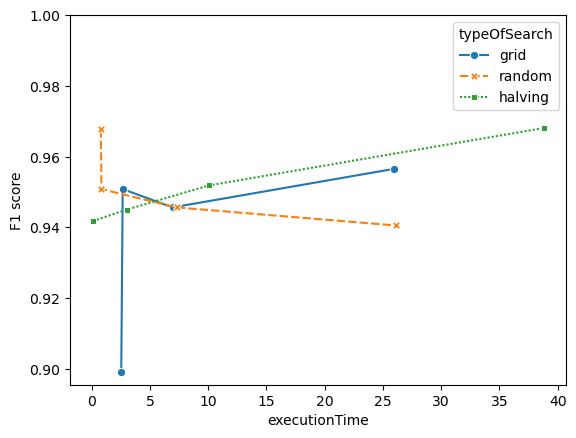

In [18]:
ax = sns.lineplot(df_results, x="executionTime", y="F1 score",hue="typeOfSearch", style="typeOfSearch", markers=True, dashes=True)
ax.set_ylim(top=1)
plt.show()

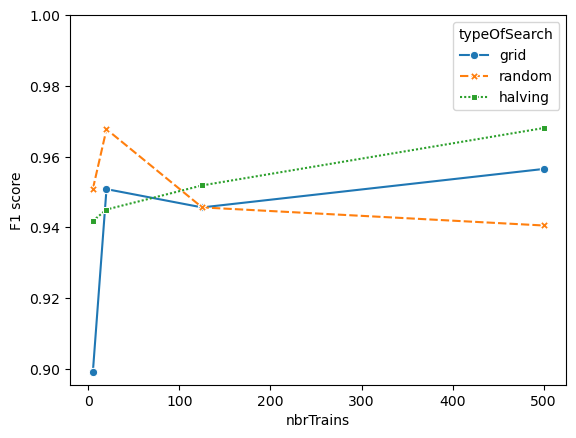

In [19]:
ax = sns.lineplot(df_results, x="nbrTrains", y="F1 score",hue="typeOfSearch", style="typeOfSearch", markers=True, dashes=True)
ax.set_ylim(top=1)
plt.show()

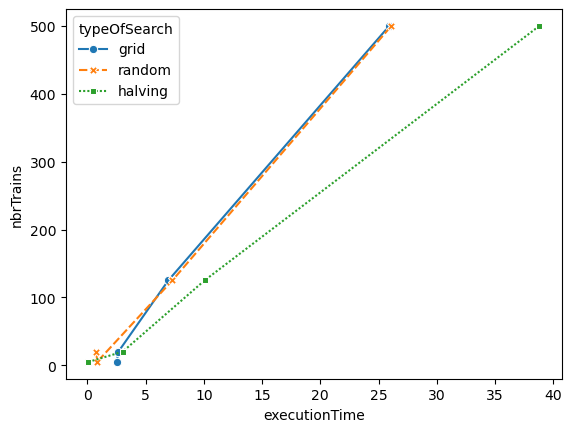

In [14]:
sns.lineplot(df_results, x="executionTime", y="nbrTrains",hue="typeOfSearch", style="typeOfSearch", markers=True, dashes=True)
plt.show()